In [8]:
from pysal.contrib.spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
from pysal.contrib.spint.dispersion import phi_disp
from pysal.contrib.spint.vec_SA import VecMoran
from pysal.weights.spintW import vecW
import pysal as ps
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%pylab inline
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import pyproj as pj
from shapely.geometry import Polygon, Point

Populating the interactive namespace from numpy and matplotlib


In [9]:
#Load NYC bike data - trips between census tract centroids
bikes = pd.read_csv(ps.examples.get_path('nyc_bikes_ct.csv'))
bikes.head()

,Unnamed: 0,count,d_cap,d_tract,distance,end station latitude,end station longitude,o_cap,o_tract,tripduration,...,d_sq_foot,diffs_out,start,end,weighted,total_out,total_in,o_hub,d_hub,od_hub
0,0,5709,255.0,600,NaN,40.712899,-73.989865,162.0,202,474.173605,...,5.914918e+07,28553756.0,202,600,0.0,56352,69165,hub,hub,hub
1,1,4010,595.0,600,NaN,40.712899,-73.989865,774.0,700,765.920864,...,5.914918e+07,28553756.0,700,600,0.0,160040,69165,hub,hub,hub
2,2,1906,170.0,600,NaN,40.712899,-73.989865,141.0,800,395.842085,...,5.914918e+07,28553756.0,800,600,0.0,34254,69165,hub,hub,non_hub
3,3,1192,255.0,600,NaN,40.712899,-73.989865,291.0,900,882.062412,...,5.914918e+07,28553756.0,900,600,0.0,46446,69165,hub,hub,non_hub
4,4,484,85.0,600,NaN,40.712899,-73.989865,57.0,1002,767.284951,...,5.914918e+07,28553756.0,1002,600,0.0,15916,69165,hub,hub,non_hub


In [10]:
#Process data

#Remove intrazonal flows
bikes = bikes[bikes['o_tract'] != bikes['d_tract']]

#Set zero attirbute values to a small constant
bikes.ix[bikes.o_sq_foot == 0, 'o_sq_foot'] = 1
bikes.ix[bikes.d_sq_foot == 0, 'd_sq_foot'] = 1
bikes.ix[bikes.o_cap == 0, 'o_cap'] = 1
bikes.ix[bikes.d_cap == 0, 'd_cap'] = 1
bikes.ix[bikes.o_housing == 0, 'o_housing'] = 1
bikes.ix[bikes.d_housing == 0, 'd_housing'] = 1

#Flows between tracts
flows = bikes['count'].values.reshape((-1,1))

#Origin variables: square footage of buildings, housing units, total station capacity
o_vars = np.hstack([bikes['o_sq_foot'].values.reshape((-1,1)),
                    bikes['o_housing'].values.reshape((-1,1)),
                    bikes['o_cap'].values.reshape((-1,1))])

#Destination variables: square footage of buildings, housing units, total station capacity
d_vars = np.hstack([bikes['d_sq_foot'].values.reshape((-1,1)),
                    bikes['d_housing'].values.reshape((-1,1)),
                    bikes['d_cap'].values.reshape((-1,1))])

#Trip "cost" in time (seconds)
cost = bikes['tripduration'].values.reshape((-1,1))

#Origin ids
o = bikes['o_tract'].astype(str).values.reshape((-1,1))

#destination ids
d = bikes['d_tract'].astype(str).values.reshape((-1,1))

print len(bikes), ' OD pairs between census tracts after filtering out intrazonal flows'

14042  OD pairs between census tracts after filtering out intrazonal flows


In [12]:
grav= BaseGravity(flows, cost)
print grav.params

[ 0.92860101]


In [4]:
#First we fit a basic gravity model and examine the parameters and model fit

grav= Gravity(flows, o_vars, d_vars, cost, 'exp')

print grav.params

print 'Adjusted psuedo R2: ', grav.adj_pseudoR2
print 'Adjusted D2: ', grav.adj_D2
print 'SRMSE: ', grav.SRMSE
print 'Sorensen similarity index: ', grav.SSI

[ 0.09898099  0.05748786  0.50319944  0.06920194  0.06408526  0.39371417
 -0.00226671]
Adjusted psuedo R2:  0.772607968896
Adjusted D2:  0.776842358473
SRMSE:  0.924994119459
Sorensen similarity index:  0.746131903797


In [5]:
#Next we fit a production-constrained model

prod = Production(flows, o, d_vars, cost, 'exp')

print prod.params[-4:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', prod.adj_pseudoR2
print 'Adjusted D2: ', prod.adj_D2
print 'SRMSE: ', prod.SRMSE
print 'Sorensen similarity index: ', prod.SSI

[ 0.00437122  0.06794379  0.85720958 -0.00227555]
Adjusted psuedo R2:  0.832399632692
Adjusted D2:  0.836963213889
SRMSE:  0.794147843751
Sorensen similarity index:  0.777965361121


In [6]:
#Next we fit an attraction-constrained model

att = Attraction(flows, d, o_vars, cost, 'exp')

print att.params[-4:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', att.adj_pseudoR2
print 'Adjusted D2: ', att.adj_D2
print 'SRMSE: ', att.SRMSE
print 'Sorensen similarity index: ', att.SSI

[ 0.05281568  0.05689814  0.85161213 -0.00229343]
Adjusted psuedo R2:  0.83252844463
Adjusted D2:  0.837094085857
SRMSE:  0.792604389868
Sorensen similarity index:  0.777557481635


In [7]:
#Finally, we fit the doubly constrained model

doub = Doubly(flows, o, d, cost, 'exp')

print doub.params[-1:] #truncate to exclude balancing factors/fixed effects

print 'Adjusted psuedo R2: ', doub.adj_pseudoR2
print 'Adjusted D2: ', doub.adj_D2
print 'SRMSE: ', doub.SRMSE
print 'Sorensen similarity index: ', doub.SSI

[-0.00232112]
Adjusted psuedo R2:  0.895575966583
Adjusted D2:  0.900342219279
SRMSE:  0.627981455879
Sorensen similarity index:  0.818294076455


In [8]:
#Next, we can test the models for violations of the equidispersion assumption of Poisson models

#test the hypotehsis of equidispersion (var[mu] = mu) against that of QuasiPoisson (var[mu] = phi * mu)
#Results = [phi, tvalue, pvalue]
print phi_disp(grav)
print phi_disp(prod)
print phi_disp(att)
print phi_disp(doub)

#We can see for all four models there is overdispersion (phi >> 0), 
#which are statistically significant according the tvalues (large)
#and pvalues (essentially zero). It does however decrease as more 
#constraints are introduced and model fit increases

[  2.99777896e+002   2.38580701e+001   4.17517731e-126]
[  2.06092255e+002   2.60328203e+001   1.05289599e-149]
[  2.07645243e+002   2.64229678e+001   3.73180686e-154]
[  1.18261248e+002   2.96580921e+001   1.33362721e-193]


In [9]:
#As a result we can compare our standard errors and tvalues for a Poisson model to a QuasiPoisson

print 'Production-constrained Poisson model standard errors and tvalues'
print prod.params[-4:]
print prod.std_err[-4:]
print prod.tvalues[-4:]

#Fit the same model using QuasiPoisson framework
Quasi = Production(flows, o, d_vars, cost, 'exp', Quasi=True)

print 'Production-constrained QuasiPoisson model standard errors and tvalues'
print Quasi.params[-4:]
print Quasi.std_err[-4:]
print Quasi.tvalues[-4:]

#As we can see both models result in the same parameters (first line)
#We also see the QuasiPoisson results in larger standard errors (middle line)
#Which then results in smaller t-values (bottom line)
#We would even consdier rejecting the statistical significant of of the 
#parameter estimate on destination building square footage because its abolsute 
# value is less than 1.96 (96% confidence level) 

Production-constrained Poisson model standard errors and tvalues
[ 0.00437122  0.06794379  0.85720958 -0.00227555]
[  5.00039382e-04   3.52444295e-04   6.85493176e-04   1.00141356e-06]
[    8.74174692   192.77880405  1250.5005361  -2272.33530432]
Production-constrained QuasiPoisson model standard errors and tvalues
[ 0.00437122  0.06794379  0.85720958 -0.00227555]
[  7.21095039e-03   5.08251633e-03   9.88533597e-03   1.44411496e-05]
[   0.60619162   13.36813995   86.71527071 -157.57383972]


In [10]:
#We can also estimate a local model which subsets the data
#For a production constrained model this means each local model
#is from one origin to all destinations. Since we get a set of 
#parameter estimates for each origin, we can then map them.

local_prod = prod.local()

In [11]:
#There is a set of local parameter estimates, tvalues, and pvalues for each covariate
#And there is a set of local values for each diagnostic

local_prod.keys()

['pvalue4',
 'pvalue2',
 'pvalue3',
 'pvalue0',
 'deviance',
 'pvalue1',
 'tvalue2',
 'tvalue3',
 'tvalue0',
 'tvalue1',
 'param3',
 'param2',
 'param1',
 'param0',
 'param4',
 'tvalue4',
 'aic']

In [12]:
#Prep geometry for plotting

#Read in census tracts for NYC
crs = {'datum':'WGS84', 'proj':'longlat'}
tracts = gp.read_file('/Users/toshan/Dropbox/Data/NYC_BIKES/nyct2010_15a/nyct2010.shp')
tracts = tracts.to_crs(crs=crs)

#subset manhattan tracts
man_tracts = tracts[tracts['BoroCode'] == '1'].copy()
man_tracts['CT2010S'] = man_tracts['CT2010'].astype(int).astype(str)

#Get tracts for which there are no onbservations
mt = set(man_tracts.CT2010S.unique())
lt = set(np.unique(o))
nt = list(mt.difference(lt))
no_tracts = pd.DataFrame({'no_tract':nt})
no_tracts = man_tracts[man_tracts.CT2010S.isin(nt)].copy()

#Join local values to census tracts
local_vals = pd.DataFrame({'betas': local_prod['param4'], 'tract':np.unique(o)})
local_vals = pd.merge(local_vals, man_tracts[['CT2010S', 'geometry']], left_on='tract', right_on='CT2010S')
local_vals = gp.GeoDataFrame(local_vals)



(40.7, 40.78)

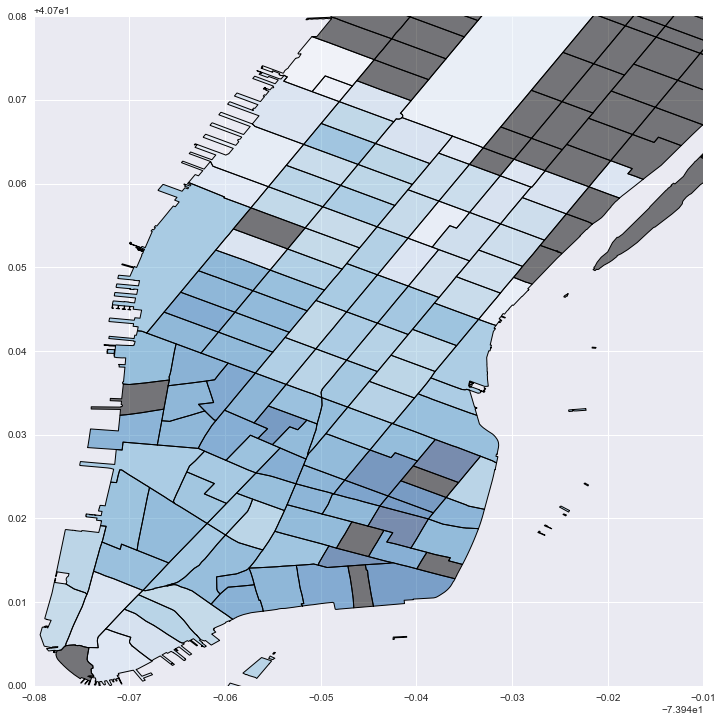

In [13]:
#Plot local "cost" values: darker blue is stronger distance decay; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['inv_betas'] = (local_vals['betas']*-1)
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('inv_betas', cmap='Blues', ax=ax)
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

(40.7, 40.78)

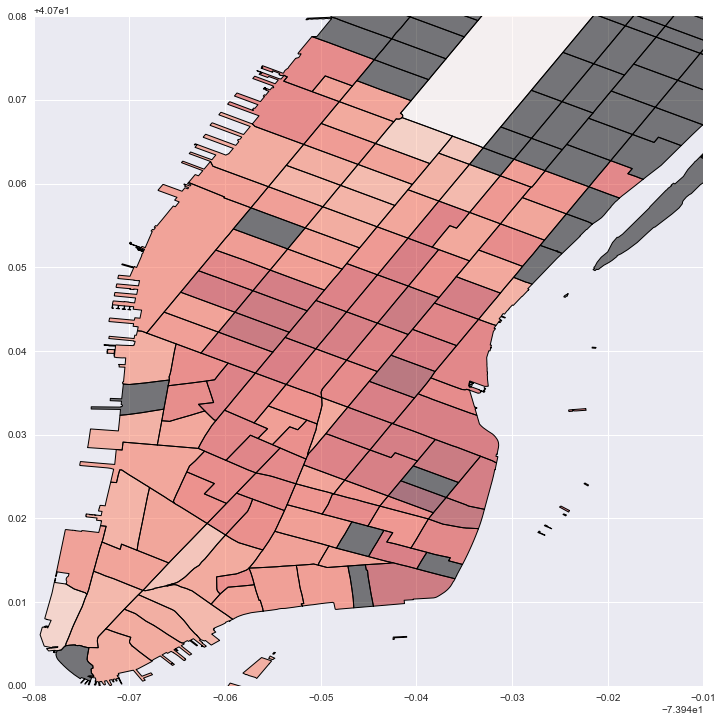

In [17]:
#Plot local estimates for destination capacity: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['cap'] = local_prod['param3']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('cap', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

(40.7, 40.78)

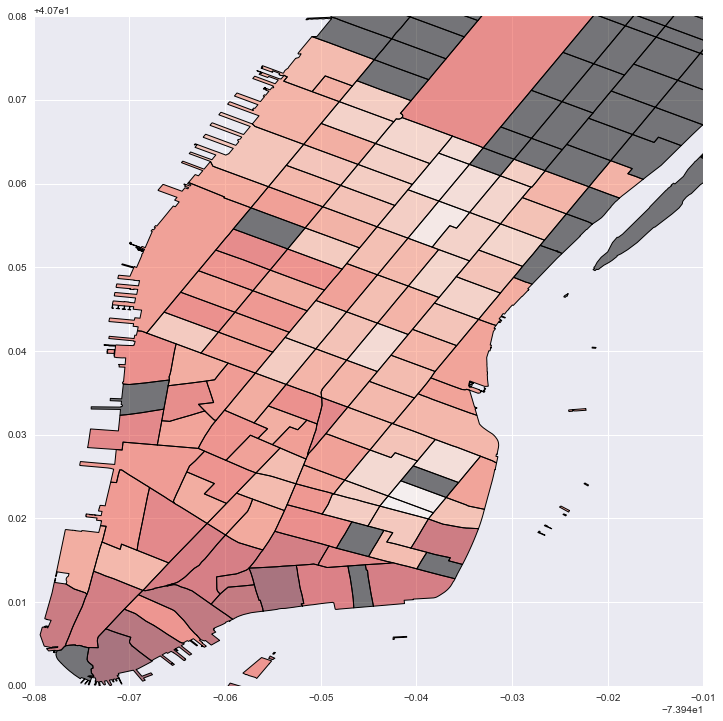

In [15]:
#Plot local estimates for # of housing units: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['house'] = local_prod['param2']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('house', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

(40.7, 40.78)

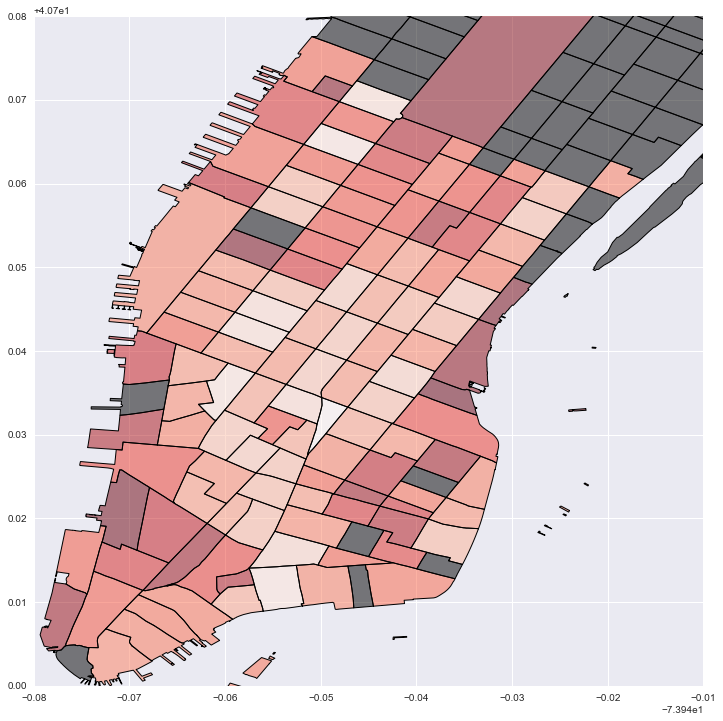

In [16]:
#Plot local estimates for destination building sq footage: darker red is larger effect; grey is no data

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['foot'] = local_prod['param1']
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('foot', cmap='Reds', ax=ax)
plt.legend()
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)

In [10]:
raw_bikes = pd.read_csv('/Users/toshan/Dropbox/Data/NYC_BIKES/CT_BIKE_DATA2.csv')
#raw_bikes = raw_bikes[0:10000]

ids = raw_bikes['index']
origin_x = raw_bikes['SX']
origin_y = raw_bikes['SY']
dest_x = raw_bikes['EX']
dest_y = raw_bikes['EY']

w = vecW(origin_x, origin_y, dest_x, dest_y, 150, binary=False)

Island ids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

In [11]:
ids = raw_bikes['index'].reshape((-1,1))
origin_x = raw_bikes['SX'].reshape((-1,1))
origin_y = raw_bikes['SY'].reshape((-1,1))
dest_x = raw_bikes['EX'].reshape((-1,1))
dest_y = raw_bikes['EY'].reshape((-1,1))


vecs = np.hstack([ids, origin_x, origin_y, dest_x, dest_y])

In [ ]:
vmo = VecMoran(vecs, w, permutations=1)

In [ ]:
vecs


In [2]:
119*119-119


14042